In [49]:
import os, sys
in_colab = 'google.colab' in sys.modules

#if your're in colab
if in_colab:
    #pull files from github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    #install required python packages
    !pip install -r requirements.txt
    #change into directory for module
    os.chdir('module3')


#import stuff
import numpy as np
import pandas as pd

#read nyc apartment rental listing data
df = pd.read_csv('../renthop-nyc.csv')
assert df.shape == (49352,34)
train, and test df cleaned# 

In [2]:
# <editor-fold desc="wrangling dDF">
import numpy as np
import pandas as pd
import io
import requests
#read nyc apartment rental listing data
url = 'https://raw.githubusercontent.com/DAVIDnHANG/DS-Unit-2-Kaggle-Challenge/master/data/apartments/renthop-nyc.csv'
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8'))) 
assert df.shape == (49352,34)
#remove less than .5 and more than .5
df = df[
    (df['price'] >= np.percentile(df['price'], 0.5)) & 
    (df['price'] <= np.percentile(df['price'], 99.5)) &
    (df['latitude'] >= np.percentile(df['latitude'], 0.5)) &
    (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
    (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
    (df['longitude'] <= np.percentile(df['longitude'], 99.95))
]
#Do train/test split
#use data from april and may 2016 to train
#use data from june 2016 to test.
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test = df[df.created >= cutoff]

# Wrangle train and test sets in the same way
def engineer_features(df):
    #avoid copy warning
    df = df.copy()
    #Does the aprtments have a description
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''
    
    #Whot long is the description
    df['description_length'] = df['description'].str.len()
    #how many total perks does each apartment have
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
        'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
        'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
        'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
        'swimming_pool', 'new_construction', 'exclusive', 'terrace',
        'loft', 'garden_patio', 'common_outdoor_space', 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)
    
    #r cats | dog allowed?
    df['cats_or_dogs'] = (df['cats_allowed'] ==1) | (df['dogs_allowed']==1)
    #r cats & dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)
    #Total number of rooms (beds+baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']
    #Extract number of days elasped in year
    df['days'] = (df['created'] - pd.to_datetime('2016-01-01')).dt.days
    df = df.drop(columns='created')
    return df
train = engineer_features(train)
test = engineer_features(test)
# </editor-fold>

In [ ]:
train.head(3)

Cross_validate_score
How do we get started? According to the Scikit-Learn User Guide
SCikit learn cross validation score, higher is better
whereas regression error metrics lower is better. so regression score gives a negative, so by -(-), the 
will represents intituive human language. 

In [ ]:
import category_encoders as ce
# <editor-fold desc="from"> from
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# </editor-fold>

# <editor-fold desc="oneHot, selectKBest  ridge">
target = 'price'
high_cardinality = ['display_address', 'street_address', 'description']
features = train.columns.drop([target]+high_cardinality)
X_train = train[features]
y_train = train[target]

Pipeline_OneHot_SelectK_Ridge = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), #replacing missing values with mean
    StandardScaler(), #standardize features by removing the mean and scaling to unit ariance
    #select top 20 features
    SelectKBest(f_regression, k=20),
    Ridge(alpha=1.0)
)

k = 3
#pass in pipeline,
#training data
#cv=k
scores = cross_val_score(
    Pipeline_OneHot_SelectK_Ridge, X_train, y_train, cv=k,
    scoring = 'neg_mean_absolute_error'
)
print(f'MAE for {k} folds:', -scores)
print('The first time')
# </editor-fold>

In [8]:
# <editor-fold desc="target Encoder, simple imputer, randomforest regressor">
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

target_random_forest = 'price'
high_cardinality_RF = ['display_address', 'street_address', 'description']
features_random_forest = train.columns.drop([target_random_forest]+high_cardinality_RF)
X_train_RF = train[features_random_forest]
y_train_RF = train[target_random_forest]

pipeline_TargetEncoder_Random = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)
k_Targetencoder_Random=4
scores_RF = cross_val_score(pipeline_TargetEncoder_Random,
                         X_train_RF, y_train_RF,
                         cv=k_Targetencoder_Random
                         )
print(-scores_RF)
# </editor-fold>

[-0.82680798 -0.84225613 -0.84141537 -0.82808622]


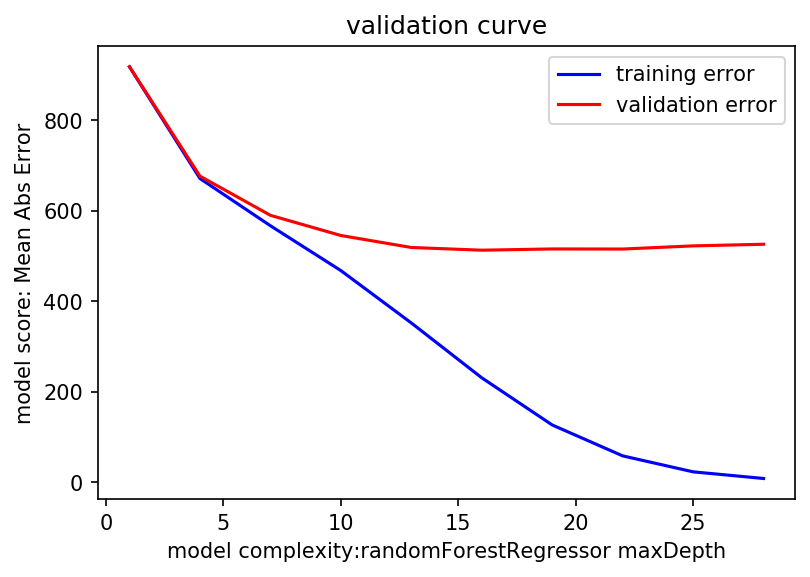

In [15]:

# <editor-fold desc="ordinaryEncoder, decision tree regressor">
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

target_S = 'price'
high_cardinality = ['display_address', 'street_address', 'description']
features_S = train.columns.drop([target_S]+high_cardinality)
X_train_S = train[features_S]
y_train_S = train[target_S]

pipeline_SimpleImputer_DecisionTree = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeRegressor()
)

depth = range(1,30,3)
train_scores, val_scores = validation_curve(
    pipeline_SimpleImputer_DecisionTree,
    X_train_S, y_train_S,
    param_name='decisiontreeregressor__max_depth',
    param_range=depth, scoring = 'neg_mean_absolute_error',
    cv=3,
    #n_jobs=-1
)
plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label ='training error')
plt.plot(depth, np.mean(-val_scores,axis=1), color='red',label='validation error')
plt.title('validation curve')
plt.xlabel('model complexity:randomForestRegressor maxDepth')
plt.ylabel('model score: Mean Abs Error')
plt.legend();
# </editor-fold>

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

target_grid = 'price'
features_grid = train.columns.drop([target_grid]+high_cardinality)
X_train_Grid = train[features_grid]
y_train_grid = train[target_grid]

pipeline_Gridsearch_Randomized = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'selectkbest__k' : range(1, len(X_train_Grid.columns)+1),
    'ridge__alpha': [0.1,1,10],
}

search = RandomizedSearchCV(
    pipeline_Gridsearch_Randomized,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)
search.fit(X_train_Grid, y_train_grid);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   12.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished


In [42]:
search.fit(X_train_Grid, y_train_grid);
X_train_Grid.dtypes


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   11.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished


bathrooms               float64
bedrooms                  int64
latitude                float64
longitude               float64
interest_level           object
elevator                  int64
cats_allowed              int64
hardwood_floors           int64
dogs_allowed              int64
doorman                   int64
dishwasher                int64
no_fee                    int64
laundry_in_building       int64
fitness_center            int64
pre-war                   int64
laundry_in_unit           int64
roof_deck                 int64
outdoor_space             int64
dining_room               int64
high_speed_internet       int64
balcony                   int64
swimming_pool             int64
new_construction          int64
terrace                   int64
exclusive                 int64
loft                      int64
garden_patio              int64
wheelchair_access         int64
common_outdoor_space      int64
has_description            bool
description_length        int64
perk_cou

In [37]:
# <editor-fold desc="making df">
import pandas as pd
import numpy as np
#import pandas as pd
import os
from sklearn.model_selection import train_test_split
#uploaded = files.upload()
#then change the filepath buffer once the file is in google.colab. also remove the file.upload() function

#name the column, adding informative names to features
#data has no header, and no footheader
#train= pd.merge(pd.read_csv('/content/test_features.csv'), pd.read_csv('/content/train_labels.csv'))
train_label_df = pd.merge(pd.read_csv('../m2w2 kaggle/train_features.csv'),  pd.read_csv('../m2w2 kaggle/train_labels.csv'))
#label =pd.read_csv('/content/train_labels.csv')
#train= pd.read_csv('/content/train_features.csv')
test_df = pd.read_csv('../m2w2 kaggle/test_features.csv')
submission_df = pd.read_csv('../m2w2 kaggle/sample_submission.csv')
# </editor-fold>

In [38]:
# <editor-fold desc="train, test, split">
from sklearn.model_selection import train_test_split
#Let Train, Validate, test then set features,target on .75 .25
train, validate = train_test_split(train_label_df, train_size = 0.75, test_size =0.25, random_state=42)
train.shape, validate.shape, test_df.shape
#I am using whole test_df to test. so let reword test_df to simply test
test = test_df
train.shape, validate.shape, test.shape
# </editor-fold>

((44550, 41), (14850, 41), (14358, 40))

In [40]:
# <editor-fold desc="train, test, split">
def wrangletwo(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangletwo(train)
val = wrangletwo(validate)
test = wrangletwo(test)

# The status_group column is the target
target_two = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features_two = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality_two = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features_two = cardinality_two[cardinality_two <= 50].index.tolist()

# Combine the lists 
features_two = numeric_features_two + categorical_features_two

X_train_two = train[features_two]
y_train_two = train[target_two]
X_val_two = val[features_two]
y_val_two = val[target_two]
X_test_two = test[features_two]
# </editor-fold>



KeyError: "['quantity_group'] not found in axis"

In [41]:
search.fit(X_train_two, y_train_two);



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.0s


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [43]:
y_train_grid

2        2850
3        3275
4        3350
5        7995
6        3600
         ... 
49346    4500
49348    3950
49349    2595
49350    3350
49351    2200
Name: price, Length: 31706, dtype: int64